# Data Modeling Exercise 1
Note: This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parametric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.


## Implement k-Nearest Neighbours (kNN)

The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

**Question 1:** Implement a class called KNNClassifier and two methods:
- `fit`: should receive the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should receive a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

**Hint**: `fit` does not need to implement any classification logic, only to save the training data and their labels in class attributes (*KNNClassifier.data*, *KNNClassifier.labels*). The classification logic should be implemented in `predict`.


In [19]:
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


In [20]:
from sklearn.base  import BaseEstimator

class kNNClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
       
    def fit(self, features, labels):
        self.features = np.array(features)
        self.labels = np.array(labels)
        
        
    def _classify(self, X):
        # Calculate X's Euclidean distance from all other samples
        diff_squared = (self.features - X) ** 2
        euclidean_distances = np.sqrt(diff_squared.sum(axis=1))
        
        # Sort index of distances 
        # keep only the first 'K' ones
        sorted_dist_indices = euclidean_distances.argsort()[:self.n_neighbors]
                
        # Count the number of classes for K nearest neighbors
        class_count = {}
        for i in sorted_dist_indices:
            vote_label = self.labels[i]
            class_count[vote_label] = class_count.get(vote_label, 0) + 1
            
        # Descending sort the resulting dictionary by class counts
        sorted_class_count = sorted(class_count.items(),
                                   key=lambda kv: (kv[1], kv[0]),
                                   reverse=True)
        
        # Return the first key in the dictionary which is the predicted label
        return sorted_class_count[0][0]
    
    
    def predict(self, test_set):
        predictions = []
        # Loop through all samples, predict the class labels and store the results
        for sample in test_set:
            predictions.append(self._classify(sample))
        
        return np.array(predictions)
    
    
    def accuracy(self, actual, preds):
        total = len(actual)
         #Calculate the number of misclassified predictions
        misclassified = sum((actual - preds) != 0)
        return (total - misclassified) / total   

## Learn and evaluate kNN algorithm on artificial data
kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set. However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value of k musst consider the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=None):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
  y[y==0] = 1
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

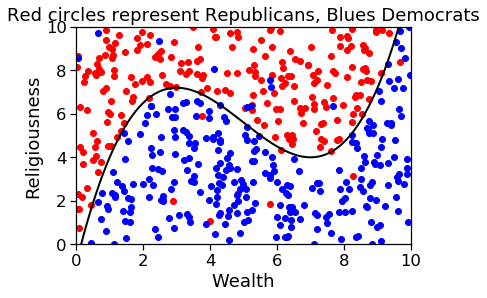

In [22]:
# Play this several times to see different sampling sets
X, y = generate_data(m=500)
plot_labeled_data(X, y)
plt.show()


### Analyse the properties of kNN
**Question 2:** Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like [that](https://drive.google.com/open?id=1jMD7I9sWT4w4O48pjwSPCFL1NLLPo10j). **Hint:** Use `np.meshgrid` for the plot ([documentation and example](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html)).

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data? 
- How does the complexity of this model depends on k?

**Question 2:  Answer**
1. Our KNN class performs better with a lower number of k than a large number.
2.  When K is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. Graphically, our decision boundary is  more jagged. On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias. Increase in dimension also leads to the problem of overfitting.
3. The noise will have a higher influence on the result, and a large number of neighbors make it computationally expensive.
<br> When we increase K, the training error will increase (increase bias), but the test error may decrease at the same time (decrease variance). We can think that when K becomes larger, since it has to consider more neighbors, its model is more complex.

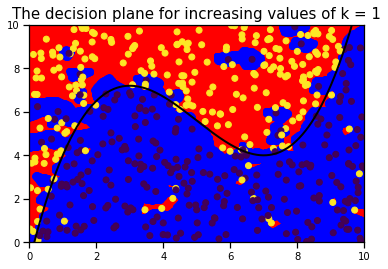

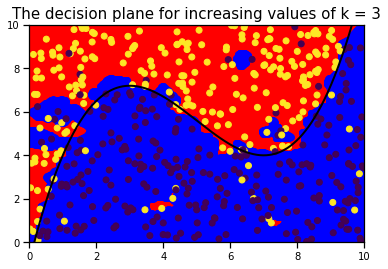

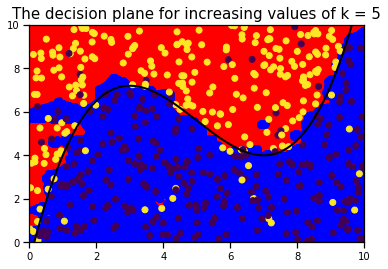

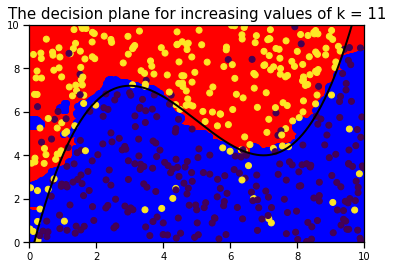

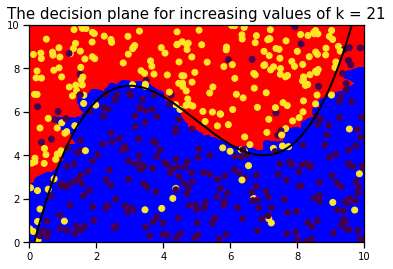

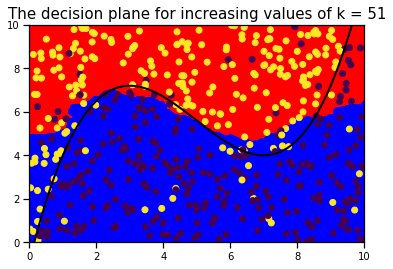

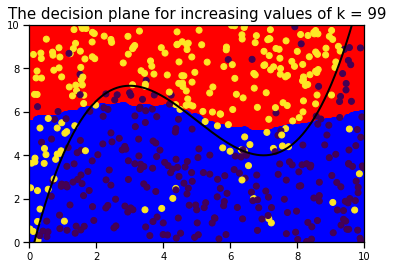

In [23]:
keys =[1, 3, 5, 11, 21, 51, 99]
X, y= generate_data(500)
X_t, y_t = generate_data(500)
h = .02  # step size in the mesh

for k in keys:
    # we create an instance of Neighbours Classifier and fit the data.
    my_classifier = kNNClassifier(k)
    my_classifier.fit(X, y)
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_t[:, 0].min() - .1, X_t[:, 0].max() + .1
    y_min, y_max = X_t[:, 1].min() - .1, X_t[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    X_t_mesh =np.c_[xx.ravel(), yy.ravel()]
    y_preds = my_classifier.predict(X_t_mesh)
    #ploting the decision plane
    plot_labeled_data(X_t_mesh,y_preds,no_titles=True)
    plt.scatter(X[:,0], X[:,1],c=y )
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('The decision plane for increasing values of k = {}'.format(k), fontsize=15)
    plt.show()


### Finding the optimal k
**Question 3:** Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? Finally, estimate the generalization error of your chosen classifier using the test set.


##### Let's sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets.

1. This sets we will use up till the end of the whole modeling-1  task

In [74]:
X, y = generate_data(1000)

2. Now let's split `X` and `y` first time into `train`, `test` and `valid` sets

In [79]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=.25,random_state=4)

print("X_train: {}% \nX_test: {}% \nX_valid: {}%\n"\
      .format(len(X_train)/len(X)*100, len(X_test)/len(X)*100, len(X_valid)/len(X)*100))

X_train: 60.0% 
X_test: 20.0% 
X_valid: 20.0%



3. Now let's calculate misclassification error for `validation` set

In [80]:
# creating odd list of K for KNN
neighbors = list(range(1, 100, 2))

accuracy_v= []
error_v= []

for k in neighbors:
    my_classifier1 = kNNClassifier(k)
    my_classifier1.fit(X_train, y_train)
    y_pred_v = my_classifier1.predict(X_valid)
    
    #creating list accuracy score
    accuracy_v.append(my_classifier1.accuracy(y_valid, y_pred_v))
    
    #calculating misclassification error
    error_v = [1 - x for x in accuracy_v]

#finding the optimal k
valid_optimal_k = neighbors[error_v.index(min(error_v))]
print('The optimal k = {}'.format(valid_optimal_k)) 

The optimal k = 3


4. And calculate misclassification error for `train` set

In [81]:
accuracy_t =[]
error_t =[]

for k in neighbors:    
    my_classifier2 = kNNClassifier(k)
    my_classifier2.fit(X_valid, y_valid)
    y_pred_t = my_classifier2.predict(X_train)
    accuracy_t.append(my_classifier2.accuracy(y_train,y_pred_t))
    
    #calculating validation misclassification error
    error_t = [1 - x for x in accuracy_t]
    
#finding the optimal k
train_optimal_k = neighbors[error_t.index(min(error_t))]
print('The optimal k = {}'.format(train_optimal_k))

The optimal k = 7


##### Plot the train vs validation error for several k values

5. Ok, Let's plot what we got

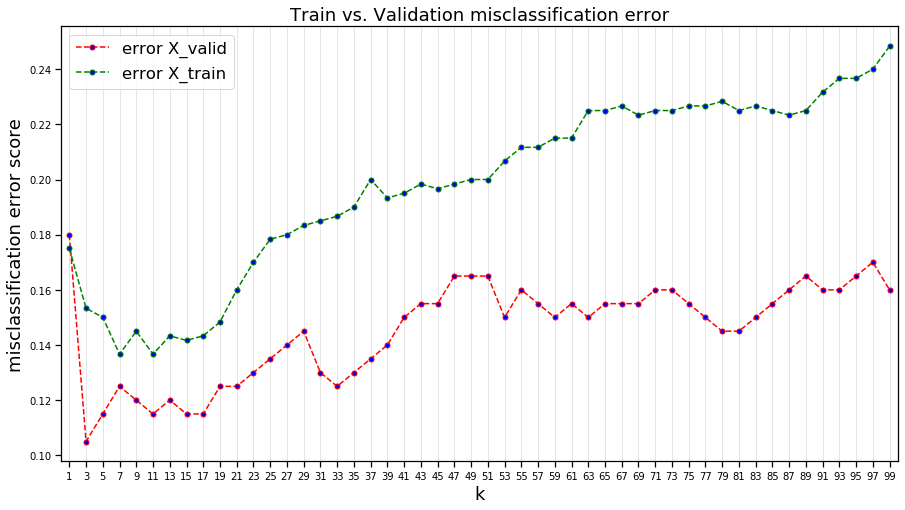

In [82]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(neighbors, error_v, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5,label='error X_valid')

plt.plot(neighbors, error_t, color='green', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5,label='error X_train')

ax.set(xlabel='k', ylabel='misclassification error score',
       title='Train vs. Validation misclassification error')

plt.xlim(0,100)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
locator = ticker.IndexLocator(base = 2, offset = 0)
ax.xaxis.set_major_locator(locator)
ax.grid(axis='x', color='grey', alpha=0.2)

plt.show()

##### Where do you underfit/overfit the data?

1. High values of k (high bias, low variance) when k > 7 (according to the train set) -> overfit
2. We approximately underfit when k < 3 (according to the validation set) 

6. It is time to calculate accuracy score for our optimal k

In [87]:
my_classifier_v = kNNClassifier(valid_optimal_k)
my_classifier_v.fit(X_train, y_train)
y_pred_valid = my_classifier_v.predict(X_valid)

print(f'For validation set optimal k = {valid_optimal_k}  our predictions are correct in {my_classifier_v.accuracy(y_valid, y_pred_v)*100}%')

my_classifier_t = kNNClassifier(train_optimal_k)
my_classifier_t.fit(X_valid, y_valid)
y_pred_train = my_classifier_t.predict(X_train)

print(f'For train set optimal k = {train_optimal_k}  our predictions are correct in {my_classifier2.accuracy(y_train,y_pred_train)*100}%')

For validation set optimal k = 3  our predictions are correct in 84.0%
For train set optimal k = 7  our predictions are correct in 86.625%


### Using cross validation
**Question 4:** This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 
What is the size of the validation and train set now, in each CV iteration?
Did your final model selection change? Explain why.

In [88]:
error_c =[]
error_t =[]

scores=[]
k_scores = []
t_scores = []

#split the 
cv = KFold(n_splits=5)

for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

# use iteration to caclulator different k in models, then return the average 
#accuracy based on the cross validation and built-in
for k in neighbors:    
    my_classifier3 = kNNClassifier(k)
    scores = cross_val_score(my_classifier3, X_train, y_train, cv=5, scoring='accuracy')
    
    my_classifier4 = kNNClassifier(k)
    my_classifier4.fit(X_train, y_train)

    y_pred = my_classifier4.predict(X_test)
    train_score = my_classifier4.accuracy(y_test,y_pred)
   
    #calculating validation misclassification error
    k_scores.append(scores.mean())
    error_c=[1 - x for x in k_scores]
    
    t_scores.append(train_score)
    error_t=[1 - x for x in t_scores]

    
#checking the size of train and test sets  which is in each iteration  
print("Train size: {}%\n".format(round(len(X_train)/len(X)*100,2)))
print("Test size: {}%\n".format(round(len(X_test)/len(X)*100,2)))
    
#finding the optimal k for cross val
cross_optimal_k = neighbors[error_c.index(min(error_c))]
print('The optimal k cross val = {}'.format(cross_optimal_k))

#finding the optimal k for train set
acc_optimal_k = neighbors[error_t.index(min(error_t))]
print('The optimal k for train set = {}'.format(acc_optimal_k))

Train size: 80.0%

Test size: 20.0%

The optimal k cross val = 5
The optimal k for train set = 7


1. We have the same size 80% x 20% `train` and `test` sets on each iteration

2. The `k` value still equal 7 in train set as it was in the previous parts of the task and 5  after using cross validation, so we don't need to change anything in our model

And now we able to plot Cross-Validated misclassification error

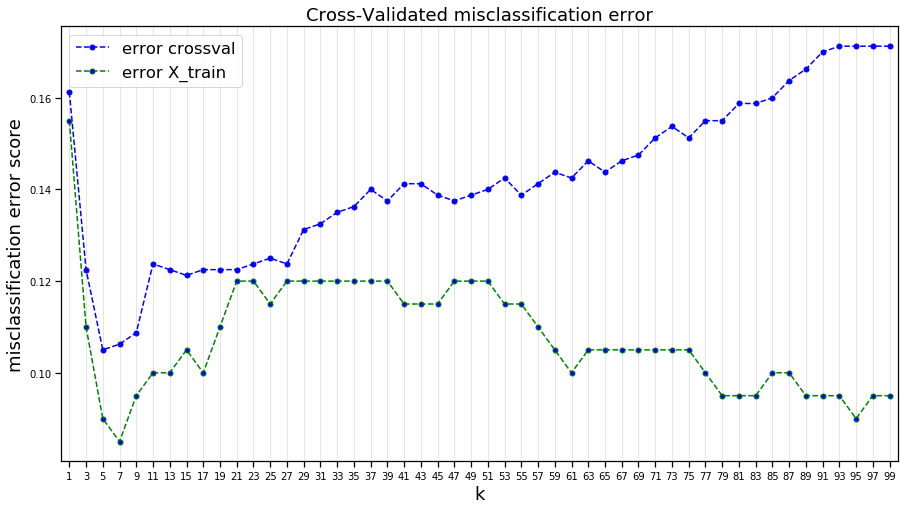

In [90]:
fig, ax = plt.subplots(figsize=(15,8))

plt.plot(neighbors, error_c, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5,label='error crossval')
plt.plot(neighbors, error_t, color='green', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=5,label='error X_train')
ax.set(xlabel='k', ylabel='misclassification error score',
       title='Cross-Validated misclassification error')

plt.xlim(0,100)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

locator = ticker.IndexLocator(base = 2, offset = 0)
ax.xaxis.set_major_locator(locator)
ax.grid(axis='x', color='grey', alpha=0.2)
plt.legend()
plt.show()

## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html
